In [1]:
import functions as f
import tokenizer_vars as tv

from Text import *
from LSTM_class import *
import constants as c

from keras import layers, models, optimizers, callbacks
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from transformers import BertTokenizer, GPT2Tokenizer
import pickle
import math

w:\anaconda3\envs\Viver\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
number_of_recipes = c.NUMBER_OF_RECIPES
tokenizer = tv.getTokenizer()

In [3]:
with open(f'data/pickle_files/indices_{number_of_recipes}.pkl', 'rb') as file:
    tokens_ind = pickle.load(file)

In [4]:
max_len = 15 #8
step = 14 #7
seq_train = Sequences(tokens_ind, max_len, step)
seq_train.sequences_info()

number of sequences of length 15: 48377


In [5]:
# print(input_train[:500])
# print(text_train.tokens[:50])
# print(text_train.tokens_ind[:50], '\n')

# np.array(seq_train.sequences[:2])

In [6]:
def lstm_model(sequence_length, vocab_size, layer_size):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, layer_size))
    model.add(layers.Bidirectional(layers.LSTM(layer_size, return_sequences=True)))
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(layer_size))
    model.add(layers.Dense(vocab_size, activation='softmax'))
    return model

In [7]:
tokenizer.get_vocab_size()

5013

In [8]:
batch_size_emb = 512 #1024

params_emb = {
    'sequence_length': max_len,
    'vocab_size': tokenizer.get_vocab_size(),
    'batch_size': batch_size_emb,
    'shuffle': True,
    'embedding': True
}

train_generator_emb = TextDataGenerator(seq_train.sequences, seq_train.next_words, **params_emb)

In [9]:
model_emb = lstm_model(max_len, len(tokenizer.get_vocab()), 512)
# optimizer = optimizers.RMSprop(lr=0.001)
optimizer = optimizers.Adam(learning_rate=0.001)
model_emb.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_emb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         2566656   
                                                                 
 bidirectional (Bidirectiona  (None, None, 1024)       4198400   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 1024)        0         
                                                                 
 lstm_1 (LSTM)               (None, 512)               3147776   
                                                                 
 dense (Dense)               (None, 5013)              2571669   
                                                                 
Total params: 12,484,501
Trainable params: 12,484,501
Non-trainable params: 0
____________________________________________

In [10]:
early_stopping_callback = callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [11]:
history = model_emb.fit(
  train_generator_emb,
  steps_per_epoch=len(train_generator_emb),
  epochs=12,
  verbose=1,
  callbacks=[
      early_stopping_callback
  ]
)

Epoch 1/12


94/94 [==============================] - 19s 150ms/step - loss: 5.2762 - accuracy: 0.1797
Epoch 2/12
94/94 [==============================] - 14s 147ms/step - loss: 4.1783 - accuracy: 0.2809
Epoch 3/12
94/94 [==============================] - 14s 151ms/step - loss: 3.7402 - accuracy: 0.3222
Epoch 4/12
94/94 [==============================] - 14s 151ms/step - loss: 3.2954 - accuracy: 0.4098
Epoch 5/12
94/94 [==============================] - 14s 147ms/step - loss: 2.9918 - accuracy: 0.4725
Epoch 6/12
94/94 [==============================] - 14s 151ms/step - loss: 2.7909 - accuracy: 0.4945
Epoch 7/12
94/94 [==============================] - 14s 152ms/step - loss: 2.6486 - accuracy: 0.5065
Epoch 8/12
94/94 [==============================] - 14s 150ms/step - loss: 2.5343 - accuracy: 0.5162
Epoch 9/12
94/94 [==============================] - 14s 153ms/step - loss: 2.4349 - accuracy: 0.5240
Epoch 10/12
94/94 [==============================] - 15s 155ms/step - loss: 2.3410 - accuracy: 0.5340


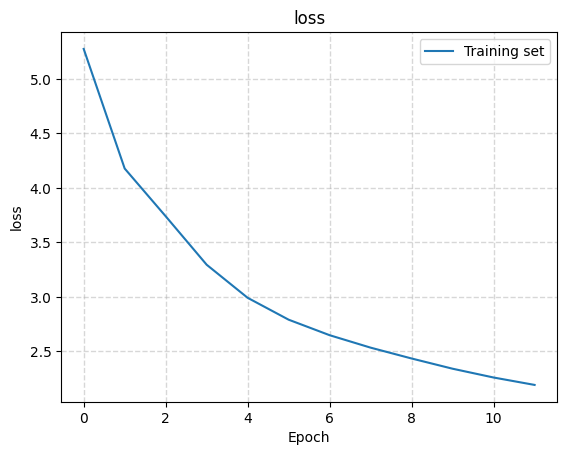

In [12]:
def render_training_history(training_history, metrics='loss'):
    metrics_history = training_history.history[metrics]

    plt.title(metrics)
    plt.xlabel('Epoch')
    plt.ylabel(metrics)
    plt.plot(metrics_history, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history, 'loss')

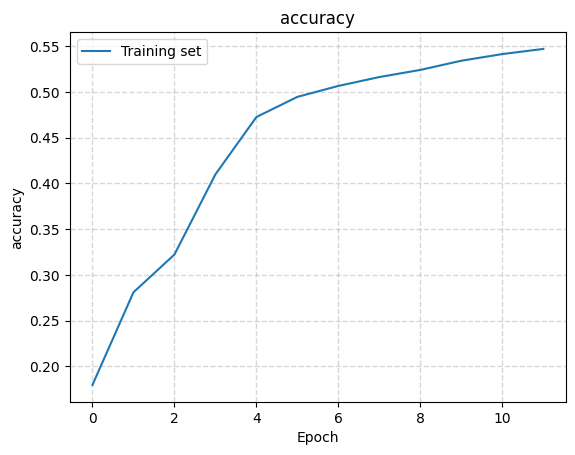

In [13]:
render_training_history(history, 'accuracy')

In [14]:
model_emb.save(f'data/out/blstm_model_{number_of_recipes}_emb_chef_tokenizer_short')

INFO:tensorflow:Assets written to: data/out/blstm_model_10000_emb_chef_tokenizer_short\assets


INFO:tensorflow:Assets written to: data/out/blstm_model_10000_emb_chef_tokenizer_short\assets
